# Notebook 2

In [1]:
# Importations des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import scipy.stats as st
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import KMeans

# Importations des données
df_billet = pd.read_csv('P6_Data/notes.csv')
df_billet_copy = df_billet.copy()

#Paramètres de style
plt.style.use('ggplot')

## Mission 2

### Application d'un algorithme de classification

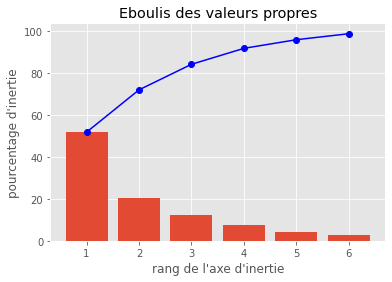

In [2]:
# Choix du nombre de composants
n_comp = 6

# Préparation des variables contenents les valeurs dans notre dataframe
X = df_billet_copy.values
names = df_billet_copy.index
features = df_billet_copy.columns

# Standardisations de nos valeurs
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

# Création du graphique de l'éboulis des valeurs propres
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="b", marker='o')

plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")

plt.savefig('P6_graphs/Eboulis des valeurs propres')
plt.show()

Dans notre cas, un choix de deux clusters prends tous sont sens, en effet, rajouter plus de clusters ne rajouteras pas plus d'informations pertinente.

In [3]:
# Clustering par K-means
km = KMeans(n_clusters = 2) # Nombres de centroïdes à générer
km.fit(X_scaled) # Calcul du positionnement de nos centroïdes

#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)

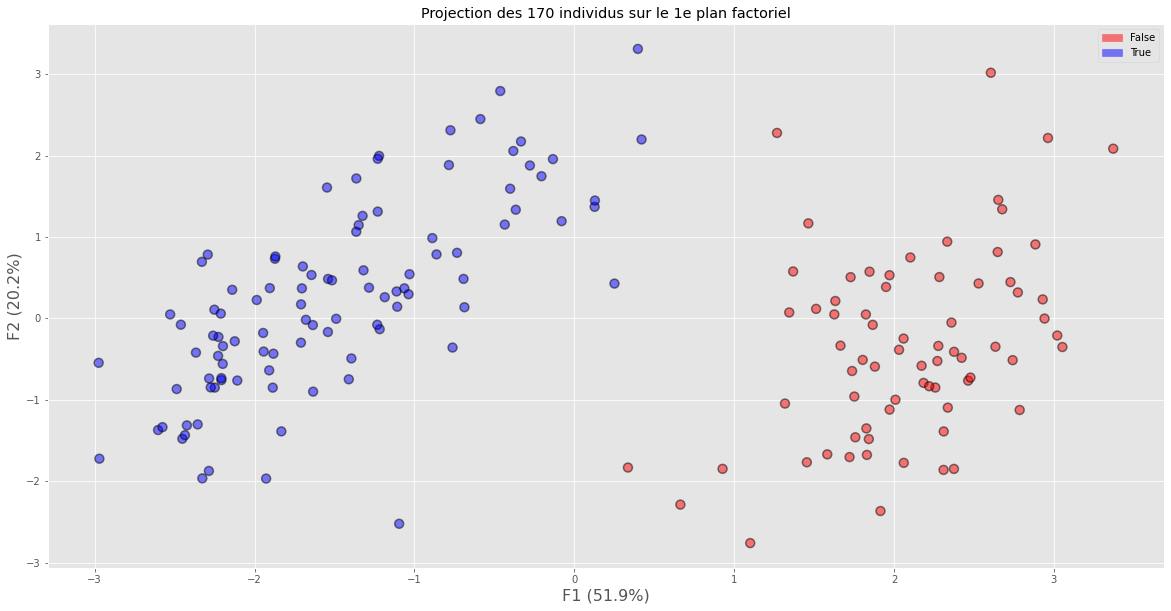

In [4]:
# Visualisation de nos deux clusters dans le premier plan factoriel
plt.figure(figsize=(20,10))

# Récupération des clusters attribués à chaque individu
clusters = km.labels_
colormap = np.array(['red', 'blue'])

plt.scatter(X_projected[:,0], X_projected[:,1], c = colormap[clusters],
            alpha = 0.5, edgecolors = 'black', linewidths=1.5, s=80)

# Légendes
# Labels de la nature des billets
lab_0 = mpatches.Patch(color='red', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize = 16) # Calcul des ratios de la variance expliquée sur la variance totale pour l'axe x
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize = 16) # Calcul des ratios de la variance expliquée sur la variance totale pour l'axe y
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.savefig('P6_graphs/projection des individus KMeans')
plt.show()

Ce graphique est très intéressant car on peut constater au premier coup d'oeil une frontière entre nos individus mais aussi une explication de la variance à hauteur de 72%.

In [5]:
# Centroïds de nos clusters
centroids = km.cluster_centers_
pd.DataFrame(centroids, columns = df_billet.columns)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,-1.16661,-0.170093,0.581698,0.693273,0.940993,0.670010,-0.969084
1,0.83666,0.121986,-0.417177,-0.497196,-0.674853,-0.480512,0.694999


In [6]:
# Intégration des clusters selon notre KMeans dans notre dataframe
df_cls = pd.DataFrame(km.fit_predict(X), columns = ['clusters']) # la méthode 'fit_predict' me permet de calculer à quels cluster appartient mon individus
df_cls = pd.concat([df_cls, df_billet_copy], axis=1)
df_cls.to_csv('df_cls') # sauvegarde nécessaire pour mon notebook_3
df_cls

,clusters,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.67,103.74,103.70,4.01,2.87,113.29
2,0,True,171.83,103.76,103.76,4.40,2.88,113.84
3,0,True,171.80,103.78,103.65,3.73,3.12,113.63
4,0,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...,...
165,1,False,172.11,104.23,104.45,5.24,3.58,111.78
166,1,False,173.01,104.59,104.31,5.04,3.05,110.91
167,1,False,172.47,104.27,104.10,4.88,3.33,110.68
168,1,False,171.82,103.97,103.88,4.73,3.55,111.87


In [7]:
# Tableau des correspondance Clusters/nature billets
corres = pd.crosstab(km.labels_, df_cls['is_genuine'])
corres.index = ['Cluster 0 - Faux', 'Cluster 1 - Vrai']
corres

is_genuine,False,True
Cluster 0 - Faux,1,100
Cluster 1 - Vrai,69,0


Notre analyse à l"aide du KMeans fonctionne trés bien, nous avons nos 170 billets qui ont été analysé et qui ont été séparés dans nos clusters(100 billets dans la catégorie 'True - Faux' ce qui correspond à notre pie chart du début d'analyse 58.8% et inversement).

# Mission 3

### Modélisation des données à l'aide d'une régression logistique

In [8]:
#Préparation des données
X = df_cls.copy()
X = X.iloc[:, 2:] # Mise à l'écart de nos valeurs qualitatif de la variable 'is_genuine'
y = df_cls.iloc[:, 1] # Stockage des valeurs de la variable 'clusters'

In [9]:
# Séparation entre les données d'entrainement et nos données test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Train set : ', X_train.shape)
print('Test set : ', X_test.shape)

Train set :  (136, 6)
Test set :  (34, 6)


j'ai choisi de diviser mes données en 80/20 car c'est ce que nous faisons généralement.

In [10]:
# Instanciation de notre modèle de régression logistique
from sklearn.linear_model import LogisticRegression

# Entrainement de nos données
lr = LogisticRegression()
lr.fit(X_train, y_train) # Entrainement de nos valeurs d'entrainement
lr.score(X_train, y_train) # résultats obtenus de cette entrainement

0.9852941176470589

Nous avons un coeff de détermination de 0.98 qui est excellent pour notre modèle d'entrainement. Essayons le maintenent sur nos valeurs test qui va nous servir d'évaluation de notre modèle.

In [11]:
from sklearn.metrics import confusion_matrix

# Prédisons les valeurs de notre variable de test
y_predict = lr.predict(X_test) # Vecteur contenant les étiquettes de classe pour chaque échantillon.

# Projetons notre prédiction dans une matrice de confusion
conf_matrix = confusion_matrix(y_test, y_predict)
print(conf_matrix)

[[13  0]
 [ 1 20]]


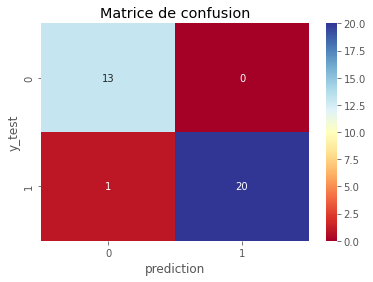

In [12]:
# Representation graphique de notre matrice de confusion
sns.heatmap(conf_matrix, cmap = 'RdYlBu', annot = True)

plt.title('Matrice de confusion')
plt.xlabel('prediction')
plt.ylabel('y_test')

plt.savefig('P6_graphs/matrice de confusion')
plt.show()

Aucun coéfficient n'a été classifié dans la mauvaise classe malgré une prédiction de nos valeurs, ce qui est excellent.

Nous pouvons désormais calculer nos prédictions sur le dataframe 'example.csv' fournit par OC pour tester notre algorithme de classification.

# Test de notre algorithme sur un nouveau dataframe 

In [13]:
# Importation de notre nouveau dataframe
df_example = pd.read_csv('P6_Data/example.csv')
df_example_copy = df_example.copy()

In [14]:
df_example_copy

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [15]:
# Préparation des données
df_example_copy = df_example_copy.iloc[:, :-1]

In [16]:
# Utilisation du modéle de prédiction
proba = lr.predict_proba(df_example_copy.values)[:, 1]

J'ai enlevé une colonne dans notre dataframe contenu dans la variable 'proba' car la fonction 'predict_proba' nous retourne un dataframe 2:2, une colonne pour savoir la probabilité(en %) que les billets sont vrai et la probabilité(en %) que les billets sont faux.

In [17]:
# Transformation de notre variable en 'séries' pour pouvoir l'ajouter à notre dataframe
proba = pd.Series(proba.round(2), name = 'probabilite')

# Ajout de cette nouvelle variable à notre dataframe
df_example_copy = pd.concat([df_example_copy, proba], axis = 1)

In [18]:
# Création d'une boucle 'for' pour ajouter une colonne qui va dire si ce sont de vrais ou faux billet selon la probabilité calculé
nature = []
for i in df_example_copy['probabilite'] >= .5:
    if i is True :
        nature.append('Vrai billet')
    else :
        nature.append('Faux billet')
    
df_example_copy['nature'] = nature
df_example_copy

,diagonal,height_left,height_right,margin_low,margin_up,length,probabilite,nature
0,171.76,104.01,103.54,5.21,3.30,111.42,0.04,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,0.01,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,0.03,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,0.86,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,0.99,Vrai billet
